**Step:1 Import Libraries**


In [17]:
import pandas as pd                      # For data manipulation and analysis
import mysql.connector                   # For connecting to MySQL database
from mysql.connector import Error        # For handling MySQL errors
import matplotlib.pyplot as plt          # For visualizations
import seaborn as sns                    # For advanced data visualization
from datetime import timedelta           # For manipulating time data

**Step:2 Create Conncection With Mysql Database**


In [18]:
def create_connection():
    try:
        # Establish a connection to the MySQL database
        connection = mysql.connector.connect(
            host='host',  # Database host
            database='database_name',  # Database name
            user='username',       # Database user
            password='password'    # Database password
        )
        # Check if the connection is successful
        if connection.is_connected():
            return connection
    except Error as e:
        # Print any error that occurs during the connection attempt
        print(f"Error: {e}")
    # Return None if the connection was not successful
    return None


**Step:3 Create Flights Table In Database**


In [19]:
def create_flights_table(connection):
    cursor = connection.cursor()
    
    # Drop the flights table if it already exists
    cursor.execute('DROP TABLE IF EXISTS flights')
    
    # Create a new flights table with the specified columns
    cursor.execute('''
    CREATE TABLE flights (
        id INT AUTO_INCREMENT PRIMARY KEY,  # Primary key with auto-increment
        FlightNumber VARCHAR(10),  # Flight number
        DepartureDateTime DATETIME,  # Departure date and time
        ArrivalDateTime DATETIME,  # Arrival date and time
        Airline VARCHAR(50),  # Airline name
        DelayMinutes INT,  # Delay in minutes
        FlightDuration INT,  # Flight duration in minutes
        DayOfWeek VARCHAR(10)  # Day of the week
    )
    ''')
    
    # Commit the transaction to save changes
    connection.commit()

**Step:4 Clean And Normalize Data**


In [20]:
def clean_and_normalize_data(df):
    # Convert date and time columns
    df['DepartureDateTime'] = pd.to_datetime(df['DepartureDate'] + ' ' + df['DepartureTime'])
    df['ArrivalDateTime'] = pd.to_datetime(df['ArrivalDate'] + ' ' + df['ArrivalTime'])
    
    # Remove duplicate entries
    df = df.drop_duplicates()
    
    # Handle missing values in DelayMinutes with mean
    df['DelayMinutes'] = df['DelayMinutes'].fillna(df['DelayMinutes'].mean())

    #df['DelayMinutes'] = df['DelayMinutes'].fillna(0)

    
    # Calculate flight duration
    df['FlightDuration'] = (df['ArrivalDateTime'] - df['DepartureDateTime']).dt.total_seconds() / 60
    
    # Correct inconsistent time entries
    mask = df['ArrivalDateTime'] <= df['DepartureDateTime']
    df.loc[mask, 'ArrivalDateTime'] += timedelta(days=1)
    df['FlightDuration'] = (df['ArrivalDateTime'] - df['DepartureDateTime']).dt.total_seconds() / 60
    
    # Add day of week
    df['DayOfWeek'] = df['DepartureDateTime'].dt.day_name()
    
    return df[['FlightNumber', 'DepartureDateTime', 'ArrivalDateTime', 'Airline', 'DelayMinutes', 'FlightDuration', 'DayOfWeek']]

**Step:5 Insert Data Into Database Table**


In [21]:
def insert_data(connection, df):
    cursor = connection.cursor()
    for _, row in df.iterrows():
        cursor.execute('''
        INSERT INTO flights (FlightNumber, DepartureDateTime, ArrivalDateTime, Airline, DelayMinutes, FlightDuration, DayOfWeek)
        VALUES (%s, %s, %s, %s, %s, %s, %s)
        ''', tuple(row))
    connection.commit()

**Step:6 Key Insights From Analysis**


In [22]:
def analyze_delays(df):
    print("===================================================================================")
    print("Key Insights :")
    print("===================================================================================")
    print("1. Average delay by airline:")
    airline_delays = df.groupby('Airline')['DelayMinutes'].mean().sort_values(ascending=False)
    print(airline_delays)
    print("===================================================================================")
    print("\n2. Correlation between departure time and delay:")
    df['DepartureHour'] = df['DepartureDateTime'].dt.hour
    correlation = df['DepartureHour'].corr(df['DelayMinutes'])
    print(f"Correlation coefficient: {correlation:.2f}")
    print("===================================================================================")
    print("\n3. Average delay by day of week:")
    day_delays = df.groupby('DayOfWeek')['DelayMinutes'].mean().sort_values(ascending=False)
    print(day_delays)
    print("===================================================================================")
    print("\n4. Flights with longest delays (top 5):")
    long_delays = df.nlargest(5, 'DelayMinutes')[['FlightNumber', 'Airline', 'DelayMinutes']]
    print(long_delays)
    print("===================================================================================")
    print("\n5. Airlines with most frequent delays (>15 minutes):")
    frequent_delays = df[df['DelayMinutes'] > 15]['Airline'].value_counts()
    print(frequent_delays)
    print("===================================================================================")
    print("\n6. Average flight duration by airline:")
    avg_duration = df.groupby('Airline')['FlightDuration'].mean().sort_values(ascending=False)
    print(avg_duration)
    print("===================================================================================")

**Step:7 Visualize Delay Analysis**


In [23]:
def visualize_delays(df):
    # Barplot: Average Delay by Airline
    plt.figure(figsize=(12, 6))
    sns.barplot(x='Airline', y='DelayMinutes', data=df)
    plt.title('Average Delay by Airline')
    plt.ylabel('Delay (minutes)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('average_delay_by_airline.png')  # Save before show
    plt.show()  # Display the plot
    plt.close()  # Close after displaying
    
    # Histogram: Delay Distribution
    plt.figure(figsize=(12, 6))
    sns.histplot(data=df, x='DelayMinutes', bins=20, kde=True)
    plt.title('Delay Distribution')
    plt.xlabel('Delay (minutes)')
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.savefig('delay_distribution.png')  # Save before show
    plt.show()  # Display the plot
    plt.close()  # Close after displaying

    # Boxplot: Delay Distribution by Day of Week
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='DayOfWeek', y='DelayMinutes', data=df)
    plt.title('Delay Distribution by Day of Week')
    plt.ylabel('Delay (minutes)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('delay_by_day_of_week.png')  # Save before show
    plt.show()  # Display the plot
    plt.close()  # Close after displaying

    # Scatterplot: Delay vs Departure Hour
    plt.figure(figsize=(12, 6))
    sns.scatterplot(x='DepartureHour', y='DelayMinutes', data=df, hue='Airline')
    plt.title('Delay vs Departure Hour')
    plt.xlabel('Departure Hour')
    plt.ylabel('Delay (minutes)')
    plt.tight_layout()
    plt.savefig('delay_vs_departure_hour.png')  # Save before show
    plt.show()  # Display the plot
    plt.close()  # Close after displaying

    #Plot Graph for Flight Number And Their Max Delays after flitering max delay from delayminutes  
    plt.figure(figsize=(12, 6))
    df1 = df.groupby('FlightNumber')['DelayMinutes'].max().nlargest(10)
    df1.plot(kind='bar')
    plt.title('Flight Number And Their Max Delays')
    plt.xlabel('Flight Number')
    plt.ylabel('Max Delay (minutes)')
    plt.tight_layout()
    plt.savefig('flight_number_max_delays.png')  # Save before show
    plt.show()  # Display the plot
    plt.close()  # Close after displaying

    #Plot Pie Chart Airlines with Most Frequent Delays >15 minutes
    plt.figure(figsize=(12, 6))
    df2 = df[df['DelayMinutes'] > 15]['Airline'].value_counts()
    df2.plot(kind='pie', autopct='%1.1f%%')
    plt.title('Airlines with Most Frequent Delays (>15 minutes)')
    plt.tight_layout()
    plt.savefig('airlines_most_frequent_delays.png')  # Save before show
    plt.show()  # Display the plot
    plt.close()  # Close after displaying

    #Plot Graph Average Flight Duration by Airline
    plt.figure(figsize=(12, 6))
    df3 = df.groupby('Airline')['FlightDuration'].mean().sort_values(ascending=False)
    df3.plot(kind='bar')
    plt.title('Average Flight Duration by Airline')
    plt.xlabel('Airline')
    plt.ylabel('Average Flight Duration (minutes)')
    plt.tight_layout()
    plt.savefig('average_flight_duration_by_airline.png')  # Save before show
    plt.show()  # Display the plot
    plt.close()  # Close after displaying
    



**Step:8 Calling All The Functions From Main()**


       FlightNumber DepartureDate DepartureTime ArrivalDate ArrivalTime  \
count            12            12            12          12          12   
unique            3             4             9           4           9   
top          AA1234    09/01/2023      08:30 AM  09/01/2023    10:45 AM   
freq              4             4             3           4           2   
mean            NaN           NaN           NaN         NaN         NaN   
std             NaN           NaN           NaN         NaN         NaN   
min             NaN           NaN           NaN         NaN         NaN   
25%             NaN           NaN           NaN         NaN         NaN   
50%             NaN           NaN           NaN         NaN         NaN   
75%             NaN           NaN           NaN         NaN         NaN   
max             NaN           NaN           NaN         NaN         NaN   

                  Airline  DelayMinutes  
count                  12     10.000000  
unique         

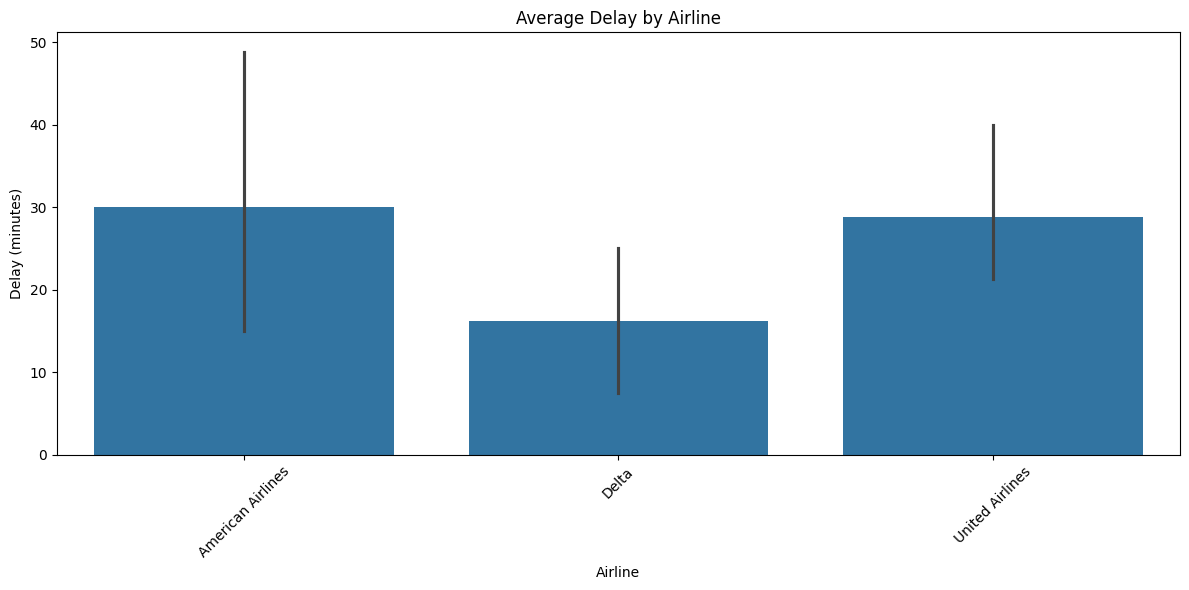

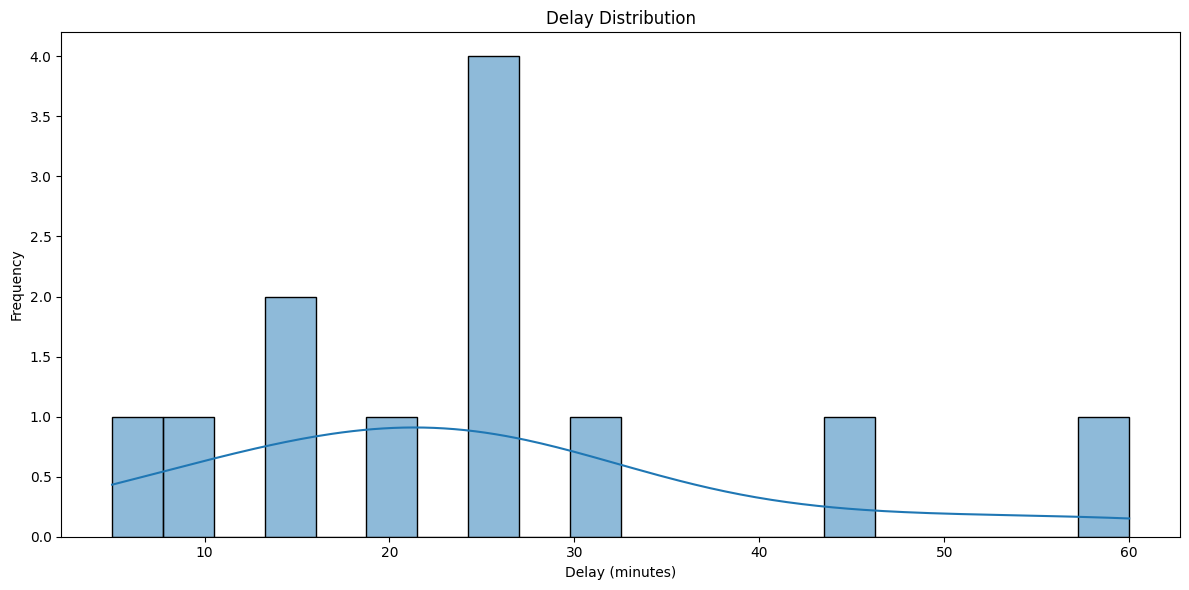

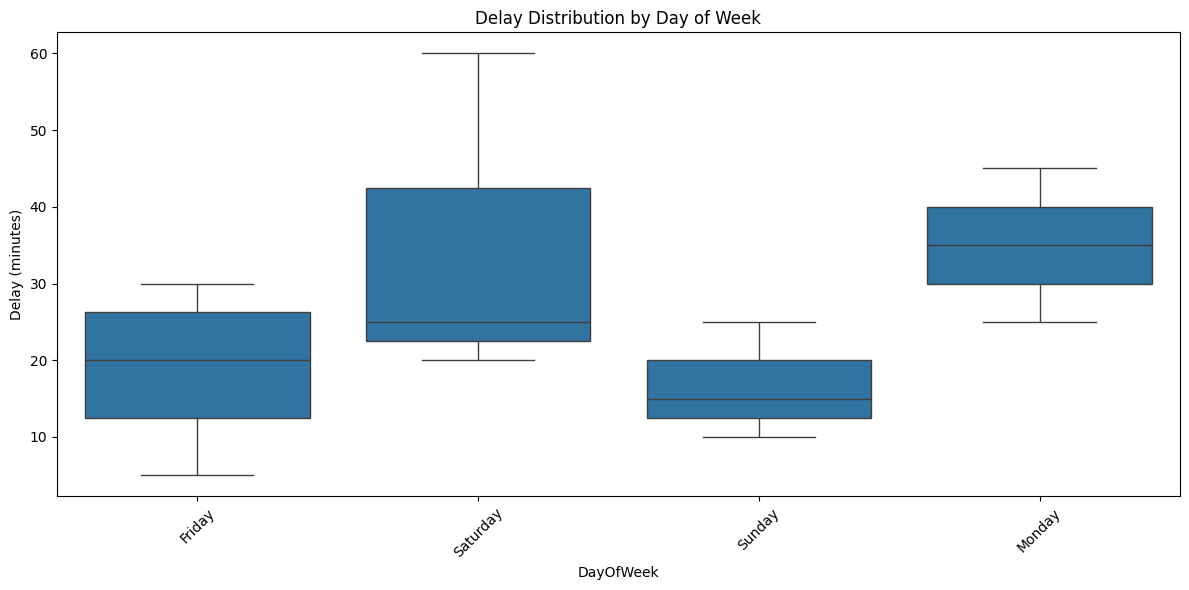

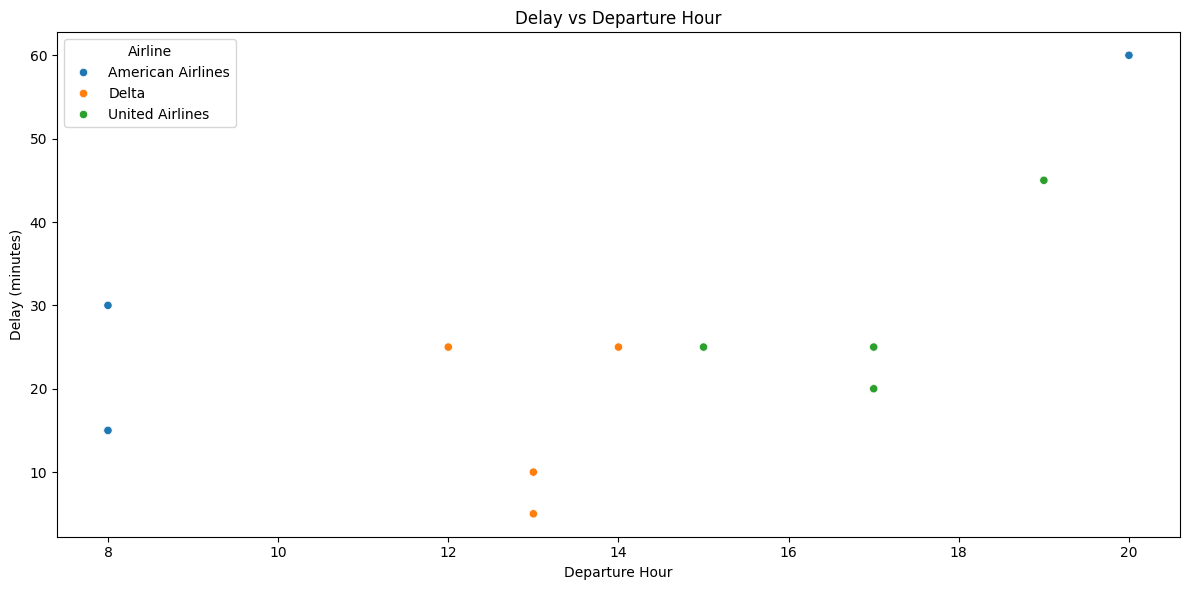

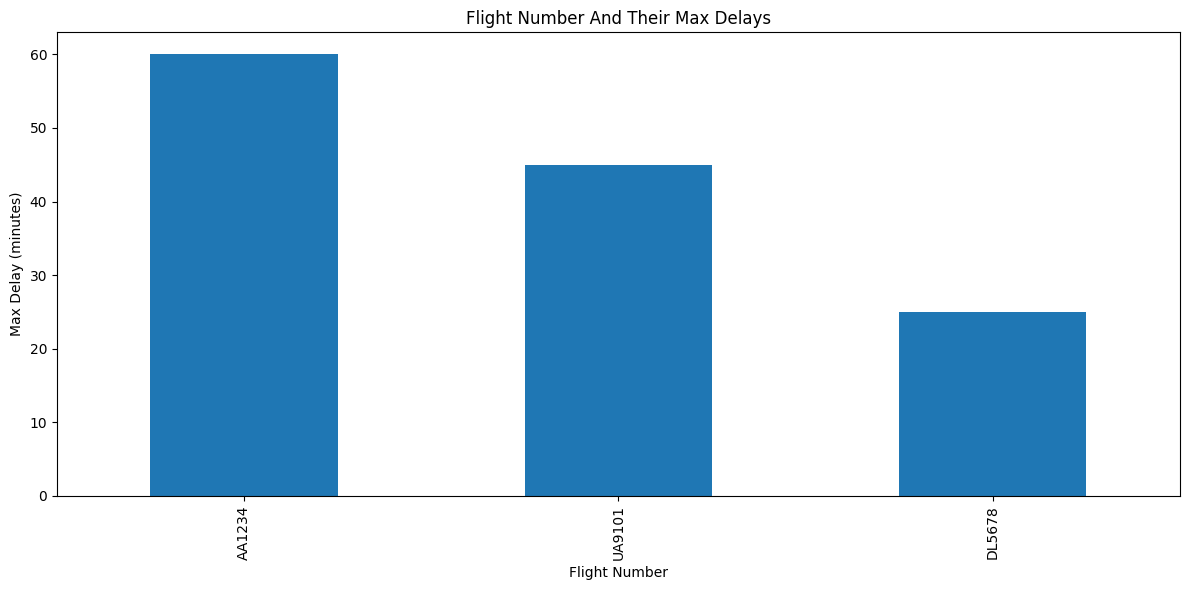

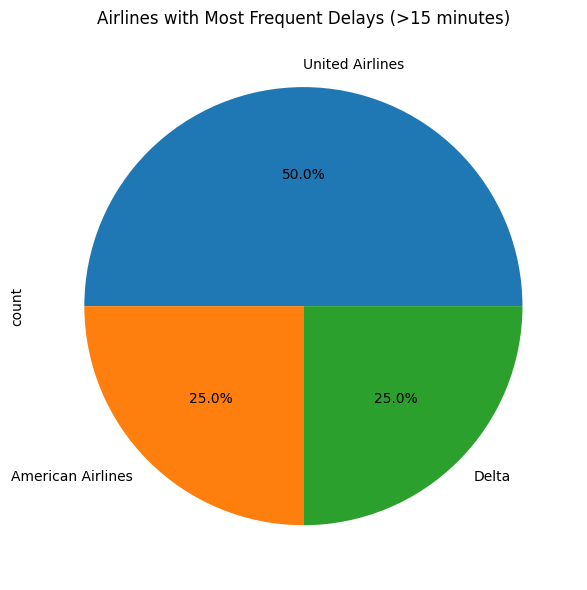

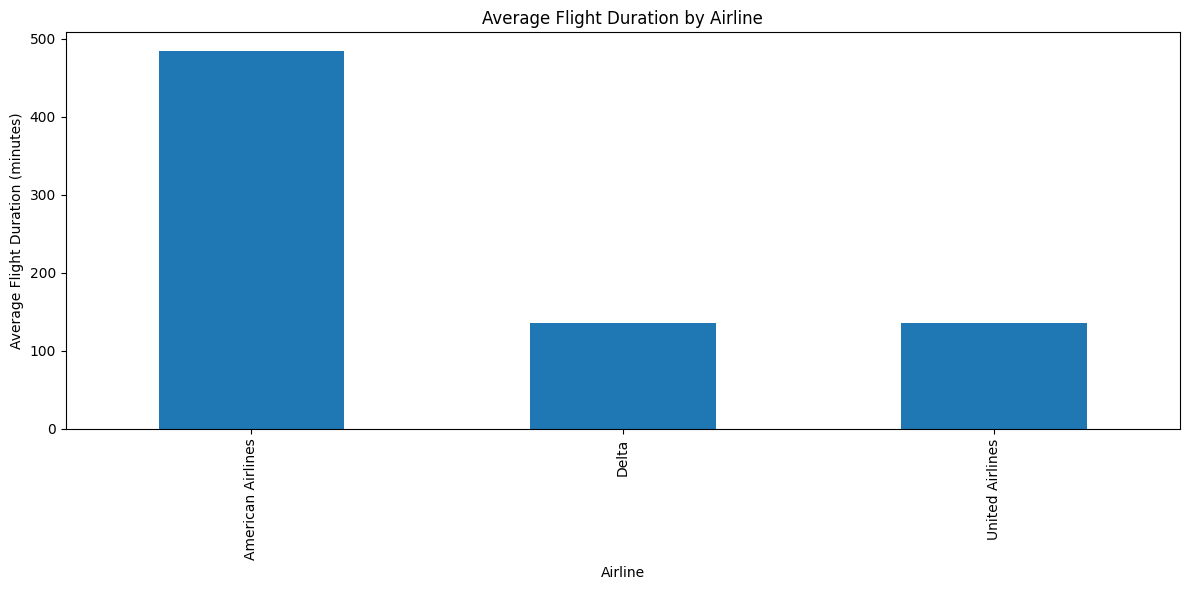

Data processing and analysis complete. Visualizations saved as PNG files.


In [24]:
def main():
   # Read CSV file
    df = pd.read_csv('aviation_data.csv')
    
    # Get a summary of the CSV data
    summary = df.describe(include='all')
    print(summary)

    # Clean and normalize data
    cleaned_df = clean_and_normalize_data(df)
    
    # Export cleaned dataset as CSV
    cleaned_df.to_csv('cleaned_aviation_data.csv', index=False)
    print("Cleaned dataset exported as 'cleaned_aviation_data.csv'")
    
    # Create MySQL connection
    connection = create_connection()
    if connection is None:
        return
    
    # Create flights table
    create_flights_table(connection)
    
    # Insert data into MySQL
    insert_data(connection, cleaned_df)
    
    # Perform data analysis
    analyze_delays(cleaned_df)
    
    # Create visualizations
    visualize_delays(cleaned_df)
    
    # Close MySQL connection
    connection.close()
    
    print("Data processing and analysis complete. Visualizations saved as PNG files.")

if __name__ == "__main__":
    main()